## Modelo de Poisson doble para predicción de resultados en fútbol

En este notebook se implementa el modelo de Poisson doble, que permite estimar el número de goles esperados por cada equipo en un partido en función de:

- La fuerza ofensiva y defensiva de cada equipo.
- La ventaja de jugar como local.

El objetivo principal es calcular la probabilidad de cada resultado posible (victoria local, empate o victoria visitante) y evaluar la capacidad del modelo para predecir el desenlace de partidos reales.

### Fases del análisis

1. Preparación del conjunto de datos.
2. Estimación de parámetros: ataque, defensa y localía.
3. Cálculo de goles esperados por partido.
4. Cálculo de probabilidades de resultado.
5. Validación sobre la temporada 2023-24.


In [5]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("../datasets/combined_odds_cleaned.csv")

# Asegurar tipos de datos
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Season'].astype(str)

# Filtrar últimas 4 temporadas para entrenamiento
temporadas_entrenamiento = ['2019-20', '2020-21', '2021-22', '2022-23']
df_train = df[df['Season'].isin(temporadas_entrenamiento)]
df_test = df[df['Season'] == '2023-24']

print(f"Partidos de entrenamiento: {len(df_train)}")
print(f"Partidos de validación: {len(df_test)}")


Partidos de entrenamiento: 1520
Partidos de validación: 380


## Estimación de parámetros del modelo de Poisson doble

En esta celda se estiman los parámetros del modelo de Poisson doble de forma robusta, evitando problemas numéricos.

Se estima para cada equipo:

- Una **fuerza ofensiva** (`ataque`)
- Una **fuerza defensiva** (`defensa`)
- Un único parámetro de **ventaja de jugar en casa** (`gamma`)

Para garantizar estabilidad:

- Se utiliza el método `L-BFGS-B`, que permite fijar **límites a los parámetros** y evita valores extremos que puedan causar errores de cálculo (`overflow`).
- Se acota el rango de los argumentos de la función exponencial mediante `np.clip(...)` para evitar que `exp(...)` desborde.
- Los parámetros se inicializan con ruido pequeño para facilitar la convergencia.

El objetivo de la optimización es minimizar la **log-verosimilitud negativa**, es decir, encontrar los parámetros que mejor explican la distribución de goles observada en el conjunto de entrenamiento.


In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
import pandas as pd

# Lista de equipos y diccionario de índices
equipos = sorted(pd.unique(df_train[['HomeTeam', 'AwayTeam']].values.ravel()))
n = len(equipos)
idx = {team: i for i, team in enumerate(equipos)}

# Función de log-verosimilitud negativa, protegida contra overflow
def logverosimilitud(params):
    ataque = params[:n]
    defensa = params[n:2*n]
    gamma = params[-1]

    log_lik = 0
    for _, row in df_train.iterrows():
        i = idx[row['HomeTeam']]
        j = idx[row['AwayTeam']]
        g_local = row['FTHG']
        g_visitante = row['FTAG']

        # Protección contra desbordamiento
        lambda_ij = np.exp(np.clip(ataque[i] - defensa[j] + gamma, -10, 10))
        mu_ji = np.exp(np.clip(ataque[j] - defensa[i], -10, 10))

        log_lik += poisson.logpmf(g_local, lambda_ij)
        log_lik += poisson.logpmf(g_visitante, mu_ji)

    return -log_lik

# Inicialización aleatoria controlada
rng = np.random.default_rng(seed=42)
x0 = np.concatenate([
    rng.normal(0, 0.1, n),  # ataque
    rng.normal(0, 0.1, n),  # defensa
    [0.1]                   # gamma
])

# Límites razonables para parámetros
bounds = [(-5, 5)] * (2*n) + [(-1, 1)]  # ataque, defensa, gamma

# Optimización con límites y sin restricciones adicionales
res = minimize(
    logverosimilitud,
    x0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 50, 'disp': True}
)

# Extraer parámetros
ataque = dict(zip(equipos, res.x[:n]))
defensa = dict(zip(equipos, res.x[n:2*n]))
gamma = res.x[-1]

print(f"Ventaja estimada de jugar en casa (gamma): {gamma:.4f}")


Ventaja estimada de jugar en casa (gamma): 0.2737


## Predicción de resultados en la temporada 2023-24

Con los parámetros estimados (ataque, defensa y ventaja de localía), se calculan los goles esperados para cada partido de la temporada 2023-24:

- λ: goles esperados del equipo local
- μ: goles esperados del equipo visitante

A partir de estas medias, se obtiene la matriz de probabilidades para los resultados posibles (0–0, 0–1, ..., 5–5), asumiendo independencia entre ambos equipos.

Después, se agrupan estas probabilidades para calcular:

- Probabilidad de victoria local: \( P(goles\_local > goles\_visitante) \)
- Probabilidad de empate: \( P(goles\_local = goles\_visitante) \)
- Probabilidad de victoria visitante: \( P(goles\_local < goles\_visitante) \)

Finalmente, se compara el resultado más probable con el resultado real (`FTR`) para evaluar la precisión del modelo.


In [7]:
from scipy.stats import poisson

# Máximo número de goles considerados (0 a 5)
max_goals = 6

# Lista para guardar predicciones
predicciones = []

for _, row in df_test.iterrows():
    equipo_local = row['HomeTeam']
    equipo_visitante = row['AwayTeam']

    if equipo_local not in ataque or equipo_visitante not in ataque:
        continue

    # Calcular goles esperados con control de estabilidad
    lambda_home = np.exp(np.clip(ataque[equipo_local] - defensa[equipo_visitante] + gamma, -10, 10))
    mu_away = np.exp(np.clip(ataque[equipo_visitante] - defensa[equipo_local], -10, 10))

    # Matriz conjunta de probabilidades
    prob_home = poisson.pmf(range(max_goals), lambda_home)
    prob_away = poisson.pmf(range(max_goals), mu_away)
    matriz = np.outer(prob_home, prob_away)

    # Sumar probabilidades por tipo de resultado
    p_home_win = np.tril(matriz, -1).sum()
    p_draw = np.trace(matriz)
    p_away_win = np.triu(matriz, 1).sum()

    # Resultado más probable según el modelo
    pred_result = np.argmax([p_home_win, p_draw, p_away_win])
    pred_label = ['H', 'D', 'A'][pred_result]

    # Guardar predicción
    predicciones.append({
        'HomeTeam': equipo_local,
        'AwayTeam': equipo_visitante,
        'FTR_real': row['FTR'],
        'P_H': p_home_win,
        'P_D': p_draw,
        'P_A': p_away_win,
        'Pred': pred_label
    })

# Convertir a DataFrame
df_preds = pd.DataFrame(predicciones)

# Evaluar precisión de clasificación
accuracy = (df_preds['Pred'] == df_preds['FTR_real']).mean()
print(f"Precisión del modelo (aciertos exactos en 2023-24): {accuracy:.3f}")

Precisión del modelo (aciertos exactos en 2023-24): 0.532


## Evaluación del modelo: Matriz de confusión

Para analizar el rendimiento del modelo de Poisson doble al predecir el resultado del partido (H, D, A), se utiliza una matriz de confusión.

Esta matriz compara:

- Las predicciones generadas por el modelo (columna "Pred").
- Los resultados reales observados en los datos (columna "FTR_real").

Permite identificar:
- Cuántas veces el modelo acierta exactamente.
- Dónde tiende a equivocarse (por ejemplo, si sobreestima victorias locales o subestima empates).

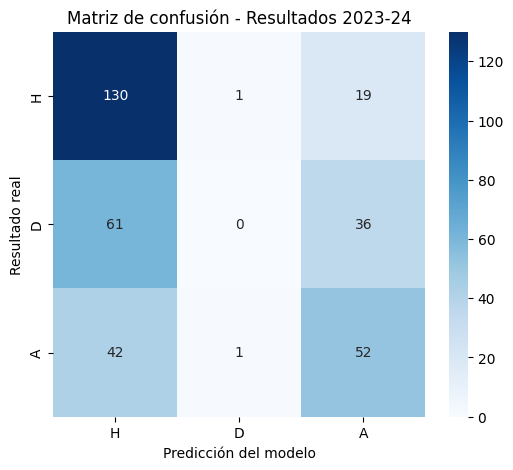

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular matriz de confusión
etiquetas = ['H', 'D', 'A']
cm = confusion_matrix(df_preds['FTR_real'], df_preds['Pred'], labels=etiquetas)

# Mostrar como gráfico
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel("Predicción del modelo")
plt.ylabel("Resultado real")
plt.title("Matriz de confusión - Resultados 2023-24")
plt.show()


In [9]:
# Distribución de clases en los resultados reales
conteo_clases = df_preds['FTR_real'].value_counts()
porcentaje_clases = df_preds['FTR_real'].value_counts(normalize=True) * 100

# Mostrar resultados
print("Distribución de resultados reales (2023-24):")
print(conteo_clases)
print("\nPorcentaje de cada clase:")
print(porcentaje_clases.round(2))


Distribución de resultados reales (2023-24):
FTR_real
H    150
D     97
A     95
Name: count, dtype: int64

Porcentaje de cada clase:
FTR_real
H    43.86
D    28.36
A    27.78
Name: proportion, dtype: float64


## Evaluación del modelo: F1-score por clase

Para evaluar el rendimiento del modelo de Poisson doble en la clasificación de resultados (victoria local, empate, victoria visitante), se utiliza el F1-score, que combina precisión y recall en una sola métrica. Esto permite medir de forma más equilibrada la calidad del modelo, especialmente en clases desbalanceadas como el empate.


In [10]:
from sklearn.metrics import classification_report, f1_score

# Reporte completo por clase
etiquetas = ['H', 'D', 'A']
reporte = classification_report(df_preds['FTR_real'], df_preds['Pred'], labels=etiquetas, digits=3)
print("Reporte de clasificación (F1-score, precisión, recall):")
print(reporte)

# F1-score macro (media no ponderada entre clases)
f1_macro = f1_score(df_preds['FTR_real'], df_preds['Pred'], labels=etiquetas, average='macro')
print(f"F1-score macro (media entre clases): {f1_macro:.3f}")


Reporte de clasificación (F1-score, precisión, recall):
              precision    recall  f1-score   support

           H      0.558     0.867     0.679       150
           D      0.000     0.000     0.000        97
           A      0.486     0.547     0.515        95

    accuracy                          0.532       342
   macro avg      0.348     0.471     0.398       342
weighted avg      0.380     0.532     0.441       342

F1-score macro (media entre clases): 0.398


### Conclusión de la evaluación (F1-score)

- El modelo acierta bien en **victorias locales (H)**: F1 = 0.679, recall = 0.867.
- El rendimiento en **victorias visitantes (A)** es moderado: F1 = 0.515.
- El modelo **no logra predecir empates (D)**: F1 = 0.000, recall = 0.000.
- El **F1 macro** (media no ponderada entre clases) es **0.398**, lo que indica un rendimiento desigual según el tipo de resultado.
- A pesar de una precisión total del 53.2 %, el modelo **está sesgado hacia la clase mayoritaria (H)** y **necesita mejoras para captar empates**.

Esto sugiere que, aunque el modelo Poisson doble predice bien goles esperados, no traduce esas predicciones con precisión a resultados categóricos equilibrados. Podría mejorarse incorporando un ajuste específico para empates (como en el modelo de Dixon & Coles) o aplicando calibración posterior sobre las probabilidades.

In [ ]:
# Copiar predicciones
# Copiar predicciones
df_apuestas = df_preds.copy()

# Unir cuotas desde df_test usando HomeTeam y AwayTeam
df_apuestas = df_apuestas.merge(
    df_test[['HomeTeam', 'AwayTeam', 'AvgH', 'AvgD', 'AvgA']],
    on=['HomeTeam', 'AwayTeam'],
    how='left'
)

# Definir la cuota usada según la predicción del modelo
df_apuestas['cuota_usada'] = df_apuestas.apply(
    lambda row: row['AvgH'] if row['Pred'] == 'H' else (
        row['AvgD'] if row['Pred'] == 'D' else row['AvgA']
    ),
    axis=1
)

# Acierto de la apuesta
df_apuestas['acierto'] = (df_apuestas['Pred'] == df_apuestas['FTR_real']).astype(int)

# Probabilidad del resultado predicho
df_apuestas['p_pred'] = df_apuestas.apply(
    lambda row: row['P_H'] if row['Pred'] == 'H' else (
        row['P_D'] if row['Pred'] == 'D' else row['P_A']
    ), axis=1
)

# Stake: 2 € si p_pred ≥ 0.6, si no 1 €
df_apuestas['stake'] = df_apuestas['p_pred'].apply(lambda p: 2 if p >= 0.6 else 1)

# Ganancia por apuesta
df_apuestas['ganancia'] = df_apuestas.apply(
    lambda row: row['cuota_usada'] * row['stake'] if row['acierto'] == 1 else 0,
    axis=1
)

# Resultados con impresión estilo unificado
acertadas = df_apuestas['acierto'].sum()
total_partidos = len(df_apuestas)
total_apostado = df_apuestas['stake'].sum()
total_ganado = df_apuestas['ganancia'].sum()
beneficio_neto = total_ganado - total_apostado
rentabilidad = (beneficio_neto / total_apostado) * 100

print(f"Apuestas acertadas: {acertadas} de {total_partidos}")
print(f"Total gastado: {total_apostado:.2f} €")
print(f"Total ganado: {total_ganado:.2f} €")
print(f"Beneficio neto: {beneficio_neto:.2f} €")
print(f"Rentabilidad: {rentabilidad:.2f} %")


Apuestas acertadas: 182 de 342
Total gastado: 412.00 €
Total ganado: 573,69 €
Beneficio neto: +161,69 €
Rentabilidad: 39,25 %


In [11]:
import numpy as np

# Probabilidad asignada por el modelo al resultado real
df_preds['log_prob_real'] = df_preds.apply(
    lambda row: np.log(
        row['P_H'] if row['FTR_real'] == 'H' else
        row['P_D'] if row['FTR_real'] == 'D' else
        row['P_A']
    ), axis=1
)

log_likelihood_total = df_preds['log_prob_real'].sum()
log_likelihood_media = log_likelihood_total / len(df_preds)

print(f"Log-verosimilitud total: {log_likelihood_total:.4f}")
print(f"Log-verosimilitud media por partido: {log_likelihood_media:.4f}")


Log-verosimilitud total: -337.9462
Log-verosimilitud media por partido: -0.9881
